In [ ]:
from IPython.core.display import display, HTML
import pygments
display(HTML("<style>.container { width:266mm !important; }</style>")) # to set cell widths
#to get this into the dissertation, 
#1. widht (above) was changed from 290 to 266 mm 
#2. exported with jupyter notebook as html (space gets wider),
#3. converted to a pdf with https://www.sejda.com/de/html-to-pdf (space gets wider again), 
#4. placed as a Verknüpfung into Adobe illustrator, where for each page separate Zeichenflächen 
#   have been chosen. For their placement the coordinate origin should be changed from "centered" 
#   to "left". 
#5. Each Zeichenfläche was saved separately and loaded in LaTeX
formatter = pygments.formatters.get_formatter_by_name('html', linenos='inline')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage

from skimage import io #to install skimage search for scikit-image
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

%config InlineBackend.figure_format = 'svg' # displaying as SVG (looks better)

## Gather fiber middle point coordinates cx, cy

C:\Users\raumann\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


ValueError: x and y must have same first dimension, but have shapes (7,) and (91,)

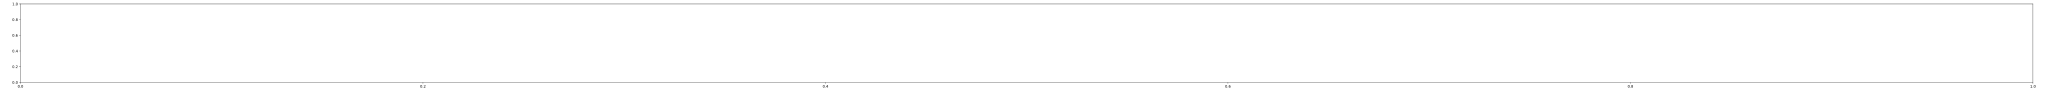

In [9]:
#### CONFIG ####################
img_path = r"C:\Daten\Auswertung\wfw_layerwise\fabric 1 - 400\masked for python\400_a_rechts_masks.tif"
file_name = "400_a_rechts"

µm_to_pxl = 0.5052955

# Number of fibers  
n = 91   

# Radii that are searched
r_min = 149/2 #[µm]
r_max = 151/2 #[µm]
hough_radii = np.arange(int(round(r_min/µm_to_pxl,0)), int(round(r_max/µm_to_pxl,0))+1, 1)

# Masking legend
brightness_pore = 0
brightness_ground = 0.33
brightness_fiber = 0.66
brightness_W = 1
################################

# Read image and convert to grayscale (2D array)
img_gray = io.imread(img_path, as_gray = True)

# Find edges (takes few minutes)
img_edges = canny(img_gray, sigma = 3)

# Detect circle
hough_res = hough_circle(img_edges, hough_radii)

# Select circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks = n)

# DataFrame for the center x- and y-coordinates 
df_Posis = pd.DataFrame({'x':cx, 'y_f':cy, 'y_b':np.nan}).sort_values('x').reset_index(drop = True)

# Find y_bottom and fill into a data frame
for i, x_i in enumerate(df_Posis['x']): 
    # start at y = image_height
    y = img_gray.shape[0] - 1     
    #go up to W (white)
    while img_gray[y, x_i] < brightness_W:
        y -= 1 
    df_Posis['y_b'].loc[i] = y + 1      
    
# Plot fiber centers, y_bottom and pore numbers
fig = plt.figure(figsize=(100, 4))
ax = plt.subplot(111)
ax.plot(df_Posis['x'][0:7], df_Posis['y_f'], '+', c = 'r')
ax.plot(df_Posis['x'][0:7], df_Posis['y_b'], 'x', c = 'r')
for PoreID in np.arange(int((df_Posis.shape[0]-1)/2)):
    ax.text(df_Posis['x'][0:7][2*PoreID + 1] - 20, df_Posis['y_b'][0:7][2*PoreID] + 100, str(PoreID))

ax.imshow(img_gray[0:img_gray.shape[0], 0:6900], cmap = plt.cm.gray)

In [3]:
df_Posis.head()

,x,y_f,y_b
0,299,660,894.0
1,752,430,890.0
2,1148,653,879.0
3,1604,452,877.0
4,2062,611,864.0


## Calculation of the rel. density and fiber vol. fraction

In [4]:
def crop_halfPore(halfPoreID):
    '''
    crops the large image to the pore fraction below two neighbored fibers
    '''
    y_min = int((df_Posis['y_f'].loc[halfPoreID] + df_Posis['y_f'].loc[halfPoreID + 1])/2)
    y_max = int((df_Posis['y_b'].loc[halfPoreID] + df_Posis['y_b'].loc[halfPoreID + 1])/2)
    x_min = df_Posis['x'].loc[halfPoreID]
    x_max = df_Posis['x'].loc[halfPoreID + 1]    

    img_halfPore = img_gray[y_min:y_max, x_min:x_max]
    return img_halfPore

def calc_d_fh__V_shift(halfPoreID):    
    # Vert dist between ground surface and lower fiber surface [µm]
    d_fh = µm_to_pxl*((df_Posis['y_b'].loc[halfPoreID] + df_Posis['y_b'].loc[halfPoreID + 1])/2
                      - max(df_Posis['y_f'].loc[halfPoreID],
                        df_Posis['y_f'].loc[halfPoreID + 1]) # lower fiber, max as origin is at top 
                      - radii.mean())
    # Vertical dist between centers of two adjacent fibers [µm]
    v_shift = µm_to_pxl*abs(df_Posis['y_f'].loc[halfPoreID] - df_Posis['y_f'].loc[halfPoreID + 1])
    return d_fh,v_shift    
    
def calc_rel_density(PoreID,controll_area):    
    halfPore_binary = (crop_halfPore(PoreID) > brightness_pore).astype(np.int)
    rel_dens = halfPore_binary.sum()/controll_area    
    return rel_dens

def calc_fiber_vol_frac(PoreID,controll_area):
    fiberParts_binary = (((brightness_ground + brightness_fiber)/2 < crop_halfPore(PoreID)) 
                         & (crop_halfPore(PoreID) < (brightness_W + brightness_fiber)/2)).astype(np.int)
    fiber_vol_frac = fiberParts_binary.sum()/controll_area    
    return fiber_vol_frac

### Use the above methods in a for loop to fill a DataFrame

In [5]:
df_halfPores = pd.DataFrame()

for halfPoreID in np.arange(0, df_Posis.shape[0] - 1, 1):
    img_halfPore = crop_halfPore(halfPoreID)
    controll_area = (img_halfPore.shape[0]*img_halfPore.shape[1]) 
    
    single_df_row = {'halfPore#': halfPoreID, 
                     'rel. Density': calc_rel_density(halfPoreID, controll_area), 
                     'Fiber vol. frac.': calc_fiber_vol_frac(halfPoreID, controll_area),
                     'controll area [Pxl²]': controll_area,
                     # Horizontal dist between two adjacent fiber centers [µm]
                     'b_in_um': round(img_halfPore.shape[1]*µm_to_pxl, 1), 
                     'd_fh_in_um': round(calc_d_fh__V_shift(halfPoreID)[0], 1),
                     'v_shift_in_um': round(calc_d_fh__V_shift(halfPoreID)[1], 1),
                    }
    
    df_halfPores = df_halfPores.append(pd.DataFrame.from_records([single_df_row],index = 'halfPore#'))
df_halfPores.head()


,rel. Density,Fiber vol. frac.,controll area [Pxl²],b_in_um,d_fh_in_um,v_shift_in_um
halfPore#,,,,,,
0,0.785643,0.225007,157191,228.9,41.9,116.2
1,0.824131,0.259497,135828,200.1,41.7,112.7
2,0.801158,0.238685,148656,230.4,38.4,101.6
3,0.771915,0.227577,155262,231.4,55.8,80.3
4,0.726130,0.226502,156140,213.2,52.0,119.2


In [6]:
df_halfPores.std()

rel. Density                0.080354
Fiber vol. frac.            0.033717
controll area [Pxl²]    24320.451160
b_in_um                    20.620216
d_fh_in_um                 24.538791
v_shift_in_um              25.031054
dtype: float64

### Use above DataFrame to calculate values for "FullPores" 
(between 3 neighbored fibers, fullpore/2 = halfpore for symmetric pores)

In [7]:
df_fullPores = pd.DataFrame()

def calc_for_fullPore(value_1,value_2,area_1,area_2):
    return  ((value_1 * area_1 + value_2 * area_2) / (area_1 + area_2))

fullPoreID = 0
for halfPoreID in np.arange(0, df_Posis.shape[0] - 2, 2):
    
    rel_density = calc_for_fullPore(df_halfPores['rel. Density'].loc[halfPoreID],
                                    df_halfPores['rel. Density'].loc[halfPoreID + 1],
                                    df_halfPores['controll area [Pxl²]'].loc[halfPoreID],
                                    df_halfPores['controll area [Pxl²]'].loc[halfPoreID + 1]
                                   )
    
    fiber_vol_frac = calc_for_fullPore(df_halfPores['Fiber vol. frac.'].loc[halfPoreID],
                                    df_halfPores['Fiber vol. frac.'].loc[halfPoreID + 1],
                                    df_halfPores['controll area [Pxl²]'].loc[halfPoreID],
                                    df_halfPores['controll area [Pxl²]'].loc[halfPoreID + 1]
                                   )
    
    # Add local position parameters to DataFrame, which can be also used as input for simulation
    x2 = df_Posis['x'].loc[halfPoreID + 1] - df_Posis['x'].loc[halfPoreID]
    x3 = df_Posis['x'].loc[halfPoreID + 2] - df_Posis['x'].loc[halfPoreID]

    y1 = df_Posis['y_b'].loc[halfPoreID] - df_Posis['y_f'].loc[halfPoreID]
    y2 = df_Posis['y_b'].loc[halfPoreID + 1] - df_Posis['y_f'].loc[halfPoreID + 1]
    y3 = df_Posis['y_b'].loc[halfPoreID + 2] - df_Posis['y_f'].loc[halfPoreID + 2]    

    single_df_row = {'fullPore#': fullPoreID, 
                     'rel. Density': rel_density, 
                     'Fiber vol. frac.': fiber_vol_frac,
                     'halfPore_left#': halfPoreID, 
                     'y1': y1*µm_to_pxl, 
                     'x2': x2*µm_to_pxl, 
                     'y2': y2*µm_to_pxl, 
                     'x3': x3*µm_to_pxl,
                     'y3': y3*µm_to_pxl
                    }
    
    df_fullPores = df_fullPores.append(pd.DataFrame.from_records([single_df_row],index = 'fullPore#'))
    fullPoreID += 1

# Export for comsol
folder = r'P:\WILMA\Leonard Raumann\Comsol\2D growing interaction asym pore\Input'
df_fullPores.to_csv(folder + r'\posis_fullPores_' + file_name + '.txt', sep = '\t', 
                    float_format = '%.1f', columns = ['x2','x3','y1','y2','y3'])

df_fullPores.head()

,rel. Density,Fiber vol. frac.,halfPore_left#,y1,x2,y2,x3,y3
fullPore#,,,,,,,,
0,0.803484,0.240995,0,118.239147,228.898862,232.435930,428.995880,114.196783
1,0.786219,0.233010,2,114.196783,230.414748,214.750587,461.840087,127.839762
2,0.734182,0.232645,4,127.839762,213.234701,246.078909,412.826424,129.860943
3,0.779179,0.227137,6,129.860943,227.888271,225.867088,449.712995,124.807989
4,0.798411,0.230827,8,124.807989,201.107609,231.930634,438.091199,125.818579


### Implementation of Algorithm 4.1 (p. 80)

In [8]:
# Output: list pores that got experimentally filled sidewards further (but not yet in the simulation) 
#         although top was sealed already

def calc_max_d_f(iPore):
    x2 = df_fullPores['x2'][iPore]
    x3 = df_fullPores['x3'][iPore]
    y1 = df_fullPores['y1'][iPore]
    y2 = df_fullPores['y2'][iPore]
    y3 = df_fullPores['y3'][iPore]
    
    d_f1f2 = (x2**2 + (y2 - y1)**2)**0.5
    d_f2f3 = ((x3 - x2)**2 + (y3 - y2)**2)**0.5
    
    return max(d_f1f2, d_f2f3) - 150    

df_pore_analy = pd.DataFrame()

for iPore in range(43):        
    max_d_g = max(df_fullPores['y1'][iPore], df_fullPores['y3'][iPore]) - 75
    filled_sidewards = 0    
    if iPore != 0:        
        if (calc_max_d_f(iPore) < calc_max_d_f(iPore - 1))\
        or (calc_max_d_f(iPore) < calc_max_d_f(iPore + 1)):
            if calc_max_d_f(iPore) < max_d_g:
                filled_sidewards = 1    
                single_df_row = {'fullPore#': iPore, 
                                 'max_d_f': calc_max_d_f(iPore), 
                                 'max_d_g': max_d_g,
                                 'maybe_fed_from_side': filled_sidewards
                                 }        
                df_pore_analy = df_pore_analy.append(pd.DataFrame.from_records([single_df_row], 
                                                                               index = 'fullPore#'))
df_pore_analy.index

Int64Index([12, 26, 35, 36, 37, 41], dtype='int64', name='fullPore#')